In [24]:
# Basic Library
import os
import pandas as pd
import numpy as np
from datetime import date,datetime
import json

# Library to work with Google Sheets
import gspread
from google.oauth2 import service_account

# Library for NSE Stock Datasets
from nsepy import get_history

#Library for Ploting
import plotly.express as px

#Library for Facebook Prophet Time Serise Model
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

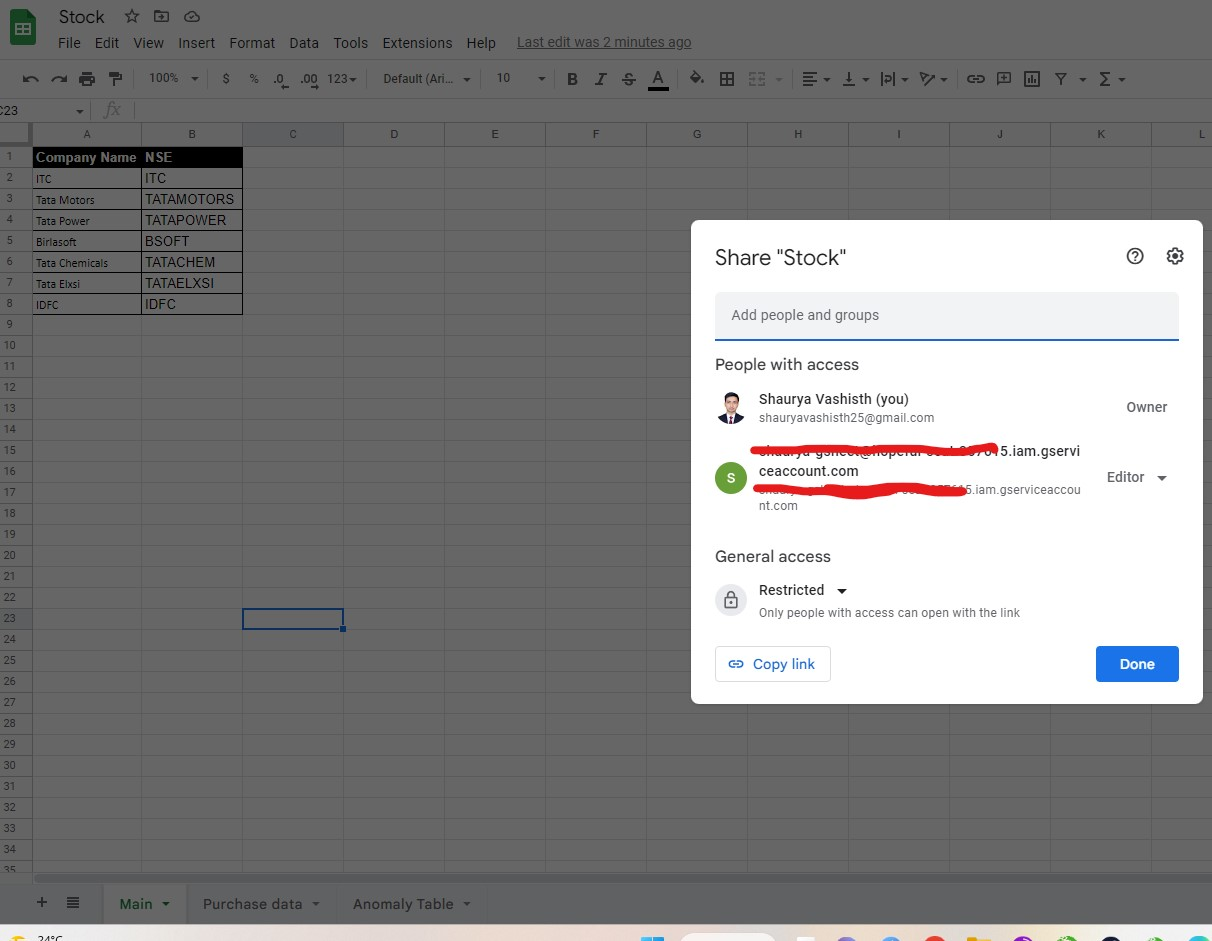

# Building Library for Google Sheet Access

In [36]:
 class google_sheet_work():
        ''' Add Google Service API Credentials of your Google Account
        Example:- gsheet = google_sheet_work('xyz.json')
        '''
        def __init__(self,json_file):
            self.json_file = json_file
            self.client = self.google_cred()
            
        def google_cred(self):
            with open(self.json_file) as json_file:
                myjson = json.load(json_file)
            credentials = service_account.Credentials.from_service_account_info(myjson)
            scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
            creds = credentials.with_scopes(scope)
            client = gspread.authorize(creds)

            return client

        def google_sheet_page(self,link,page_name):
            ''' do share the ID of your google credentials to the sheet that is shared example:-'abc-xyz@xxxx-xxx-xxxx.iam.gserviceaccount.com'
            link:- Put the Google Sheet Link.
            page_name:- Put the sheet name from the sheet of which link is added
            Example:- gsheet.google_sheet_page(https://docs.google.com/spreadsheets/d/......,'Main Sheet')
            '''
            page = self.client.open_by_url(link)
            page = page.worksheet(page_name)
            page = page.get_all_records()
            page = pd.DataFrame.from_dict(page)

            return page
        
        def update_gsheet(self,link,page_name,df_to_be_updated,from_row_num):
            page = self.client.open_by_url(link)
            page = page.worksheet(page_name)
            page.insert_rows(df_to_be_updated.values.tolist(),row=from_row_num)
            print('Google Sheets Updated at {}'.format((datetime.now().time()).strftime('%I:%M %p')))

# Using the Library to get the Required Sheets
#### 1. calling the Authentication file (json)
#### 2. saving the Link into a variable
#### 3. Calling the data from the google sheets to the variables in a table form
#### 4. forming the list of NSE company Code

In [37]:
Link = 'Your Link Here'

In [38]:
gsheet= google_sheet_work('google authentication key.json')
Stock_Code = gsheet.google_sheet_page(Link,'Main')

In [39]:
Stock_list = Stock_Code['NSE'].to_list()
Stock_list.remove('TATAELXSI')
Stock_list

['ITC', 'TATAMOTORS', 'TATAPOWER', 'BSOFT', 'TATACHEM', 'IDFC']

# Creating the loop to get all the stocks data from 2021-01-01 till today for all the stocks mentioned in the google sheets

In [40]:
# formed variable as per todays date
Today_Year = int((date.today()).strftime('%Y'))
Today_Month = int((date.today()).strftime('%m'))
Today_Day = int((date.today()).strftime('%d'))

#formed a blank dataframe and added a loop to get the data from 2021-01-01 till todays date for the stockes from google sheets
consolidated_stock_data = pd.DataFrame()
for i in Stock_list:
    Stock_data = get_history(symbol=i,
                   start=date(2021,1,1),
                   end=date(Today_Year,Today_Month,Today_Day))[['Symbol','Close']]
    consolidated_stock_data = pd.concat([consolidated_stock_data,Stock_data])

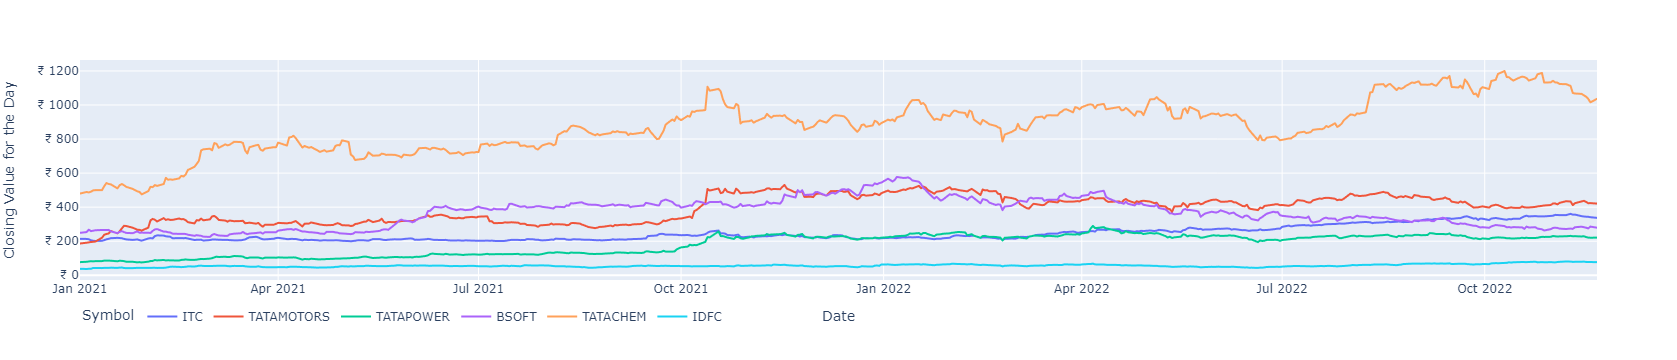

In [41]:
fig_1 = px.line(consolidated_stock_data, 
                y='Close',color='Symbol',
                hover_data = ['Close'],labels={"Close": "Closing Value for the Day"})
fig_1.update_yaxes(tickprefix="₹ ")
fig_1.update_layout(legend=dict(orientation="h"))
fig_1.show()

In [42]:
consolidated_stock_data = consolidated_stock_data.reset_index()
consolidated_stock_data['Date'] = pd.to_datetime(consolidated_stock_data['Date'])
# Purchase_Data = gsheet.google_sheet_page(Link,'Purchase data')
# Purchase_Data['Date'] = pd.to_datetime(Purchase_Data['Date'],format='%d-%m-%Y')
# day_closing_values = Purchase_Data.merge(consolidated_stock_data.reset_index(),left_on=['Date','Company'],right_on=['Date','Symbol'])[['Date','Company','Qty','Close']]
# day_closing_values['Total Day Value'] = day_closing_values['Qty']*day_closing_values['Close']
# day_closing_values.pivot_table(index='Company',values=['Total Day Value'],aggfunc='sum',margins=True)

# Creating a Funtion to train the data with Prophet Model with Hyperparameter tuning

In [43]:
def fit_prophet_anomaly_model(dataframe,Symbol):
    dataframe = dataframe.loc[(dataframe['Symbol']==Symbol)]
    dataframe_final = dataframe.reset_index()
    dataframe_final = dataframe_final.rename(columns={'Date':'ds','Close':'y'})
    print('Number of Availabe dates:-',len(dataframe_final['ds']))
    param_grid = {'changepoint_prior_scale': [1],
        'seasonality_prior_scale': [1],
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_range': [0.9],
        'daily_seasonality':[False], 
        'yearly_seasonality':[True],
        'weekly_seasonality' : [True],
        'n_changepoints': [50],
        'interval_width':[0.99]
    }
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    print('Total Combination in Hyperparameter Tuning:-',len(all_params))
    # Create a list to store MAE values for each combination
    maes = [] 
    # Use cross validation to evaluate all parameters
    for params in all_params:
        # Fit a model using one parameter combination
        m = Prophet(**params).fit(dataframe_final)  
        # Cross-validation
        df_cv = cross_validation(m, initial='{} days'.format(len(dataframe_final['ds'])-30), period='10 days', horizon = '20 days', parallel="processes")
        # Model performance
        df_p = performance_metrics(df_cv, rolling_window=1)
        # Save model performance metrics
        maes.append(df_p['mae'].values[0])

    # Tuning results
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mae'] = maes
    # Find the best parameters
    best_params = all_params[np.argmin(maes)]
    print('Seasonality Mode Type:-',best_params['seasonality_mode'])
    # Fit the model using the best parameters
    auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
                        seasonality_prior_scale=best_params['seasonality_prior_scale'],
                        seasonality_mode=best_params['seasonality_mode'],
                        changepoint_range = best_params['changepoint_range'],
                        daily_seasonality = False, 
                        yearly_seasonality = True, 
                        weekly_seasonality = True,
                        n_changepoints=best_params['n_changepoints'],
                        interval_width=best_params['interval_width']
                        )
    # Fit the model on the training dataset
    auto_model.fit(dataframe_final)
    # Cross validation
    auto_model_cv = cross_validation(auto_model, initial='{} days'.format(len(dataframe_final['ds'])-30), period='10 days', horizon = '20 days', parallel="processes")
    # Model performance metrics
    auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
    forecast = auto_model.predict(dataframe_final)
    forecast['True Value'] = dataframe_final['y'].reset_index(drop = True)
    forecast['Stock'] = Symbol

    return auto_model,forecast

In [44]:
auto_model,forecast = fit_prophet_anomaly_model(consolidated_stock_data,'IDFC')

Number of Availabe dates:- 467
Total Combination in Hyperparameter Tuning:- 2
Seasonality Mode Type:- additive


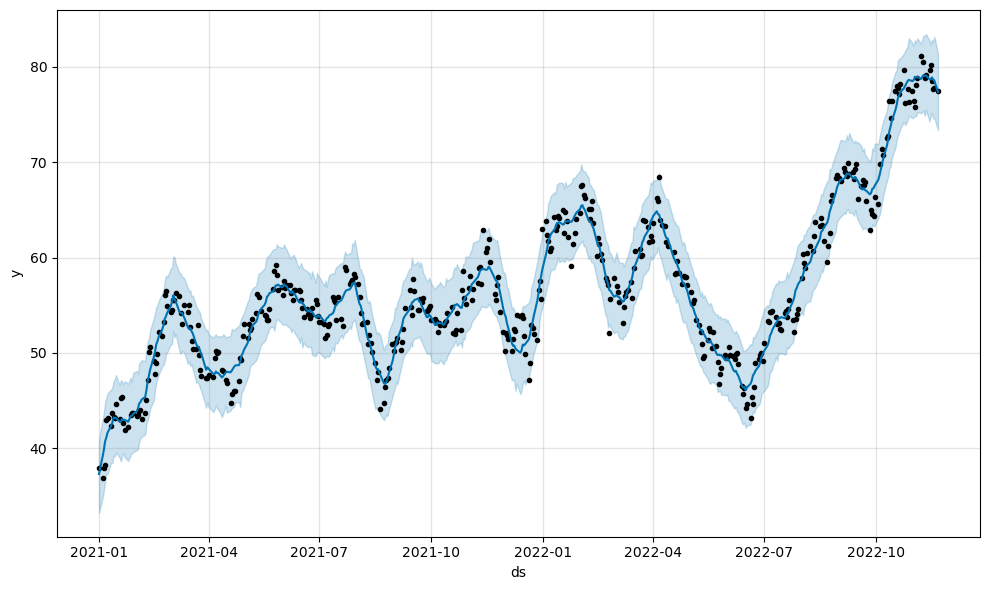

In [45]:
auto_model.plot(forecast);

In [48]:
def anomalay(forecast_df):
    forecast_df['Anomaly'] = 0
    forecast_df.loc[forecast_df['True Value']>forecast_df['yhat_upper'], 'Anomaly'] = 1
    forecast_df.loc[forecast_df['True Value']<forecast_df['yhat_lower'], 'Anomaly'] = -1
    forecast_df = forecast_df[(forecast_df['Anomaly']==1)|(forecast_df['Anomaly']==-1)]
    forecast_df = forecast_df.reset_index(drop=True)
    forecast_df = forecast_df.rename(columns={'ds':'Date','yhat':'Predicted Value'})
    forecast_df['Date'] = forecast_df['Date'].dt.strftime('%Y-%m-%d')
    forecast_df = forecast_df[['Date','Predicted Value', 'True Value','Stock','Anomaly']]
    
    return forecast_df

In [49]:
anomalay_table = anomalay(forecast)
anomalay_table

,Date,Predicted Value,True Value,Stock,Anomaly
0,2021-12-13,50.025424,53.85,IDFC,1
1,2021-12-20,51.442312,47.15,IDFC,-1
2,2021-12-31,58.732757,63.00,IDFC,1
3,2022-01-24,63.736160,59.15,IDFC,-1
4,2022-02-24,56.583475,52.05,IDFC,-1
5,2022-08-22,63.668140,59.55,IDFC,-1
6,2022-09-26,66.621118,62.85,IDFC,-1


In [51]:
gsheet.update_gsheet(link=Link,page_name='Anomaly Table',df_to_be_updated = anomalay_table,from_row_num = 2)

Google Sheets Updated at 01:21 PM


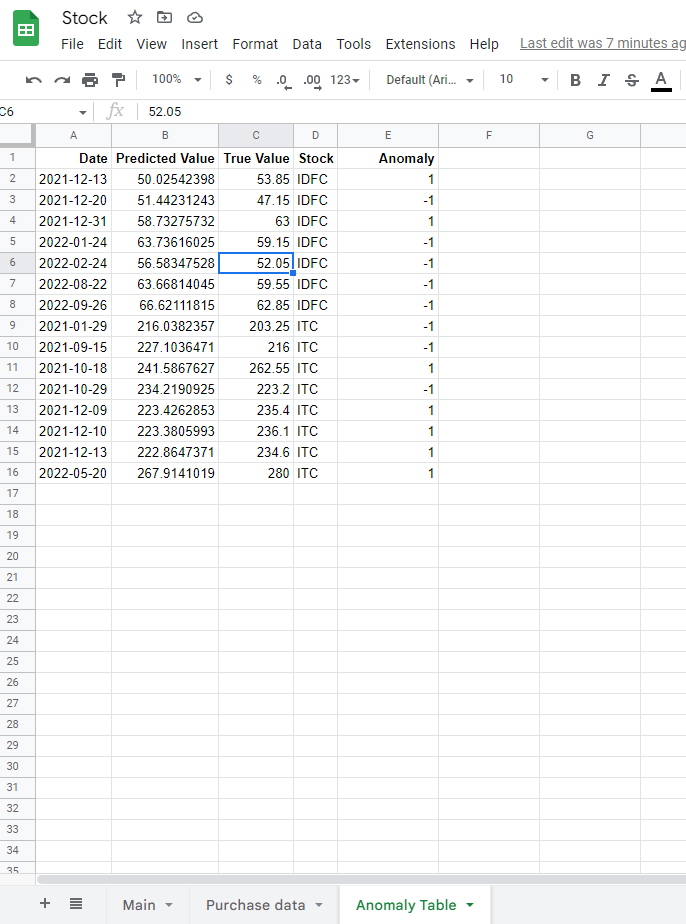